In [1]:
!pip install pyspark


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.style.use('ggplot')
sns.set_style("whitegrid")

from scipy import stats

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.regression import GBTRegressor

In [3]:
conf = SparkConf().set("spark.ui.showConsoleProgress", "false")
sc = SparkContext(appName="Salary Prediction using Pyspark", conf=conf)
sc

<SparkContext master=local[*] appName=Salary Prediction using Pyspark>

In [4]:
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("ERROR")

In [5]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

c:\Users\Vansh Aggarwal\anaconda3\lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [9]:
df1 = spark.read.csv("train_dataset.csv", header=True).cache()
df1.show(5)

+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|    major|industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|  HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|     WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|  PHYSICS|  HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL|CHEMISTRY|    AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|  PHYSICS| FINANCE|              8|                 16|
+----------------+---------+--------------+-----------+---------+--------+---------------+-------------------+
o

In [11]:
df2 = spark.read.csv("train_salaries.csv", header=True).cache()
df2.show(5)

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
+----------------+------+
only showing top 5 rows



In [12]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: string (nullable = true)
 |-- milesFromMetropolis: string (nullable = true)



In [13]:
df2.printSchema()


root
 |-- jobId: string (nullable = true)
 |-- salary: string (nullable = true)



In [14]:
df1 = df1.withColumn("yearsExperience",df1.yearsExperience.cast('int'))
df1 = df1.withColumn("milesFromMetropolis",df1.milesFromMetropolis.cast('int'))

In [15]:
df2 = df2.withColumn("salary", df2.salary.cast('int'))

In [16]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



In [17]:
df2 = df2.withColumnRenamed('jobId', 'job_id')

In [18]:
df = df1.join(df2, df1.jobId==df2.job_id)

In [19]:
df = df.drop('job_id')

In [20]:
df.show(5)

+----------------+---------+--------------+--------+----------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|  degree|     major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+--------+----------+---------+---------------+-------------------+------+
|JOB1362684407739|    COMP5|        JUNIOR| MASTERS|   BIOLOGY|  FINANCE|             11|                 72|    88|
|JOB1362684407746|   COMP11|VICE_PRESIDENT| MASTERS|LITERATURE|  SERVICE|             10|                  5|   106|
|JOB1362684407774|   COMP44|        JUNIOR|DOCTORAL| CHEMISTRY|      WEB|             19|                 35|   162|
|JOB1362684407797|   COMP51|       MANAGER|DOCTORAL|   COMPSCI|  SERVICE|             22|                  9|   207|
|JOB1362684407807|   COMP48|        SENIOR|DOCTORAL|      MATH|EDUCATION|             11|                 66|    75|
+----------------+---------+--------------+--------+----------+-

In [21]:
df_dup=df.groupBy("yearsExperience", "milesFromMetropolis","companyId","jobType", "degree", "major", "industry", "jobId").count().filter("count > 1")
df_dup.drop('count').show()

+---------------+-------------------+---------+-------+------+-----+--------+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|
+---------------+-------------------+---------+-------+------+-----+--------+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+



In [22]:
print('Number of missing values for jobType: {}'.format(df.filter(df.jobType=='NONE').count()))
print('Number of missing values for degree: {}'.format(df.filter(df.degree=='NONE').count()))
print('Number of missing values for major: {}'.format(df.filter(df.major=='NONE').count()))
print('Number of missing values for industry: {}'.format(df.filter(df.industry=='NONE').count()))

Number of missing values for jobType: 0
Number of missing values for degree: 236854
Number of missing values for major: 532355
Number of missing values for industry: 0


In [23]:
df.describe(['yearsExperience', 'milesFromMetropolis','salary']).show()

+-------+-----------------+-------------------+-----------------+
|summary|  yearsExperience|milesFromMetropolis|           salary|
+-------+-----------------+-------------------+-----------------+
|  count|          1000000|            1000000|          1000000|
|   mean|        11.992386|           49.52926|       116.061818|
| stddev|7.212390868885726| 28.877732628720015|38.71793638113313|
|    min|                0|                  0|                0|
|    max|               24|                 99|              301|
+-------+-----------------+-------------------+-----------------+



In [25]:
df.createOrReplaceTempView("data") #to perform sql queries

In [26]:
spark.sql('''
    SELECT salary, jobtype, industry
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
+------+-------+--------+



In [27]:
df_q2 = spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary DESC) Rank
          FROM data
          ORDER BY salary DESC
          LIMIT 20''')
df_q2.show(20)

+------+-------+--------+----+
|salary|jobtype|industry|Rank|
+------+-------+--------+----+
|   301|    CFO|     OIL|   1|
|   301|    CTO|     OIL|   1|
|   298|    CEO|     OIL|   3|
|   294|    CEO| FINANCE|   1|
|   294|    CEO|     OIL|   4|
|   293|    CEO| FINANCE|   2|
|   293|    CEO|     OIL|   5|
|   292|    CTO| FINANCE|   3|
|   292|    CEO| FINANCE|   3|
|   290|    CEO|     WEB|   1|
|   289|    CFO|     OIL|   6|
|   289|    CTO|     WEB|   2|
|   289|    CEO| FINANCE|   5|
|   288|    CFO| FINANCE|   6|
|   288|    CFO| FINANCE|   6|
|   287|    CEO|     OIL|   7|
|   287|    CEO| FINANCE|   8|
|   286|    CEO|     OIL|   8|
|   286|    CTO| FINANCE|   9|
|   286|    CEO| FINANCE|   9|
+------+-------+--------+----+



In [28]:
spark.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''').show()

+------+--------------+---------+----+
|salary|       jobtype| industry|Rank|
+------+--------------+---------+----+
|     0|VICE_PRESIDENT|      WEB|   1|
|     0|       MANAGER|  FINANCE|   1|
|     0|        JUNIOR|      OIL|   1|
|     0|        JUNIOR|     AUTO|   1|
|     0|           CTO|     AUTO|   1|
|    17|       JANITOR|EDUCATION|   1|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    20|       JANITOR|EDUCATION|  15|
+------+--------------+---------+----+
only showing top 20 rows



In [29]:
df = df.where("salary != 0")

In [30]:
df.createOrReplaceTempView("data")

In [31]:
df_q4 = spark.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC''')
df_q4.show(10)

+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



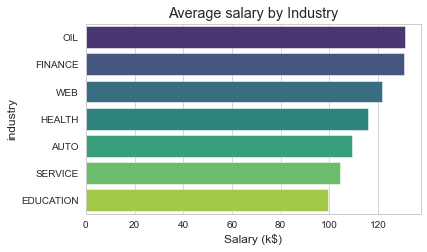

In [32]:
df_p = df_q4.toPandas()
plt.figure(figsize=(6,3.5))
sns.barplot(y='industry', x = 'average_salary', data=df_p, palette='viridis')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

In [33]:
df_q5 = spark.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''') 
df_q5.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CFO|     OIL|             23|
|   301|    CTO|     OIL|             24|
|   298|    CEO|     OIL|             22|
|   294|    CEO| FINANCE|             24|
|   294|    CEO|     OIL|             19|
|   293|    CEO| FINANCE|             16|
|   293|    CEO|     OIL|             24|
|   292|    CEO| FINANCE|             22|
|   292|    CTO| FINANCE|             24|
|   290|    CEO|     WEB|             20|
|   289|    CEO| FINANCE|             23|
|   289|    CFO|     OIL|             23|
|   289|    CTO|     WEB|             24|
|   288|    CFO| FINANCE|             24|
|   288|    CFO| FINANCE|             21|
|   287|    CEO|     OIL|             22|
|   287|    CEO| FINANCE|             19|
|   286|    CEO|     OIL|             16|
|   286|    CTO| FINANCE|             24|
|   286|    CEO| FINANCE|             24|
+------+-------+--------+---------

In [34]:
df_q5.groupBy('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [35]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR','JANITOR']


In [36]:
df_p = df_q5.toPandas()

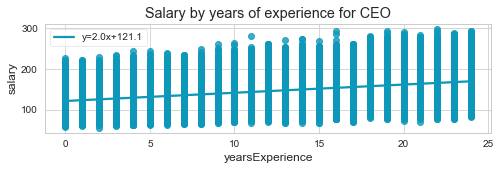

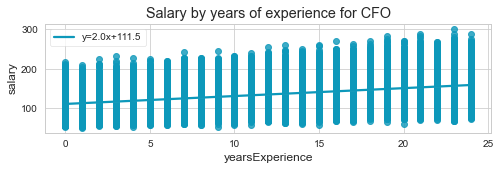

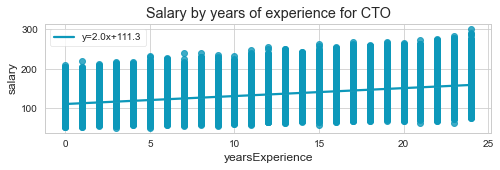

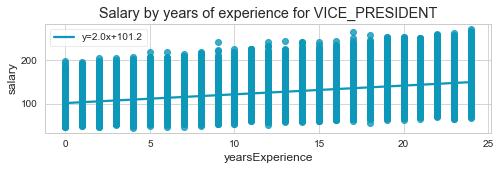

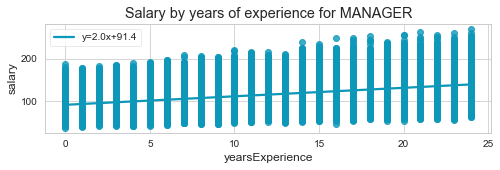

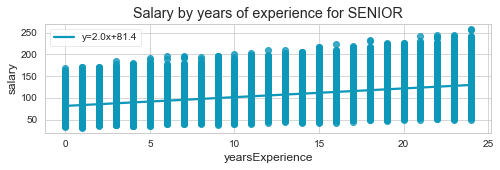

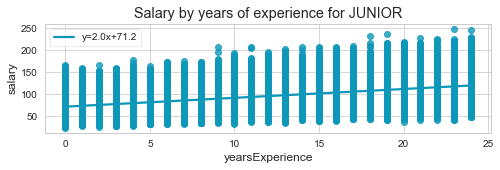

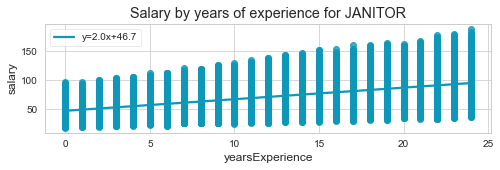

In [37]:
slope_list = []  #to save the slopes of the regression lines
intercept_list = [] #to save the intercepts of the regression lines

for job in job_list:
    df_x = df_p.loc[df_p['jobtype']==job]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salary by years of experience for ' + job)
    plt.show()

In [38]:
df_q6 = spark.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary
                  ''')
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|       NONE|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [39]:
df_q6 = df_q6.replace('NONE',None)

In [40]:
df_q6 = df_q6.na.drop()

In [41]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [42]:
df_q6.groupBy('degree').count().show()

+-----------+------+
|     degree| count|
+-----------+------+
|  BACHELORS|175495|
|    MASTERS|175310|
|   DOCTORAL|175362|
|HIGH_SCHOOL|236975|
+-----------+------+



In [43]:
degrees_list = ['HIGH_SCHOOL','BACHELORS','DOCTORAL','MASTERS']

In [44]:
df_p = df_q6.toPandas()

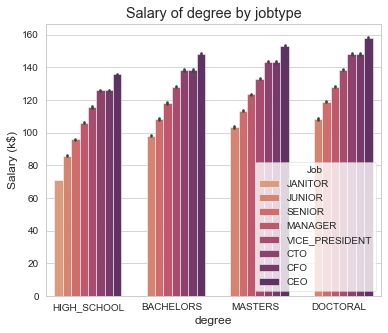

In [46]:
plt.figure(figsize=(6,5))
sns.barplot(x='degree', y = 'salary', data=df_p, hue='jobtype', palette='flare')
plt.legend(loc='lower right', title='Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of degree by jobtype')
plt.show()

In [47]:
df_q7 = spark.sql('''
                  SELECT jobtype, degree, major, salary
                  FROM data
                  ORDER BY salary''')
df_q7.show(5)

+-------+-----------+-----+------+
|jobtype|     degree|major|salary|
+-------+-----------+-----+------+
|JANITOR|       NONE| NONE|    17|
|JANITOR|       NONE| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|       NONE| NONE|    19|
+-------+-----------+-----+------+
only showing top 5 rows



In [48]:
df_q7 = df_q7.replace('NONE',None)
df_q7 = df_q7.na.drop()

In [49]:
df_q7.groupBy('major').count().show()

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY|58379|
|ENGINEERING|58594|
|    PHYSICS|58410|
|  CHEMISTRY|58875|
|   BUSINESS|58518|
|    COMPSCI|58382|
|       MATH|57800|
| LITERATURE|58684|
+-----------+-----+



In [50]:
df_q7.groupBy('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO|66885|
|        JUNIOR|66465|
|           CFO|66427|
|           CEO|66754|
|       MANAGER|66832|
|VICE_PRESIDENT|66771|
|        SENIOR|67508|
+--------------+-----+



In [51]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']

In [52]:
df_p = df_q7.toPandas()

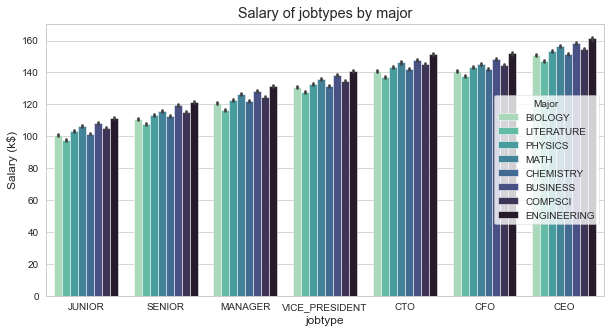

In [53]:
plt.figure(figsize=(10,5))
sns.barplot(x='jobtype', y = 'salary', data=df_p, hue='major', palette='mako_r')
plt.legend(loc='center right', title='Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of jobtypes by major')
plt.show()

In [54]:
df_encoded = df.alias('df_encoded')
id(df_encoded) == id(df)  # False

False

In [55]:
df_encoded = df_encoded.drop('jobId')

In [56]:
cols = df_encoded.columns

In [57]:
salary_df = df_encoded.select('salary').toPandas()

In [58]:
#label encoding 

categoricalColumns = ["companyId","jobType", "degree", "major", "industry"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [59]:
stages = []
stringIndexer = StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

In [60]:
#one hot encoding

categoricalColumns = ["companyId","jobType", "major", "industry"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [61]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_encoded)
df_encoded = pipelineModel.transform(df_encoded)
selectedCols = ['features'] + cols
df_encoded = df_encoded.select(selectedCols)

In [62]:
df_encoded.show(1)

+--------------------+---------+-------+-------+-------+--------+---------------+-------------------+------+
|            features|companyId|jobType| degree|  major|industry|yearsExperience|milesFromMetropolis|salary|
+--------------------+---------+-------+-------+-------+--------+---------------+-------------------+------+
|(86,[43,68,76,79,...|    COMP5| JUNIOR|MASTERS|BIOLOGY| FINANCE|             11|                 72|    88|
+--------------------+---------+-------+-------+-------+--------+---------------+-------------------+------+
only showing top 1 row



In [63]:
train, test = df_encoded.randomSplit([0.995, 0.005], seed = 42)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 995057 training examples and 4938 test examples.


In [64]:
gbt =  GBTRegressor(featuresCol="features", labelCol="salary", maxBins=20, maxDepth=12)

In [65]:
gbt_model = gbt.fit(train)

In [66]:
predictions = gbt_model.transform(test)

In [67]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

19.061981887835177

In [68]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.7594726075849147

In [69]:
rf_results = predictions.toPandas()

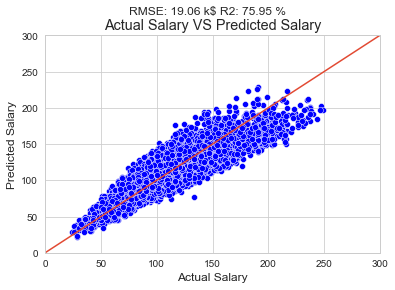

In [70]:
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

In [71]:
print("RMSE: {:.2f} k$ \nR2: {:.2f} %".format(rmse, r2*100))

RMSE: 19.06 k$ 
R2: 75.95 %


In [72]:
spark.stop()